In [1]:
import pandas as pd

In [18]:
import importlib

import src.ingest_clean 
importlib.reload(src.ingest_clean)
from src.ingest_clean import *

import src.feature_engineering 
importlib.reload(src.feature_engineering)
from src.feature_engineering import *

import src.utils 
importlib.reload(src.utils)
from src.utils import *

import src.modeling 
importlib.reload(src.modeling)
from src.modeling import *

import src.eval_visuals 
importlib.reload(src.eval_visuals)
from src.eval_visuals import *

## Introduction

### Download data from DANE; five departaments : Antioquia, Córdoba, Chocó, Nariño, Cauca 

In [ ]:
cnpv_fetch_per_hog_top5() # fetch the data from DANE webpage for the top 5 departaments with historical malaria issues
combine_cnpv_per_hog() # Combine the datasets fetched in the first step 

### Download malaria data and plot by departaments


Top 5 departments by cases:
department  cases
     CHOCO 297749
 ANTIOQUIA 236677
   NARIÃO 154261
   CORDOBA 126418
  GUAVIARE  35762


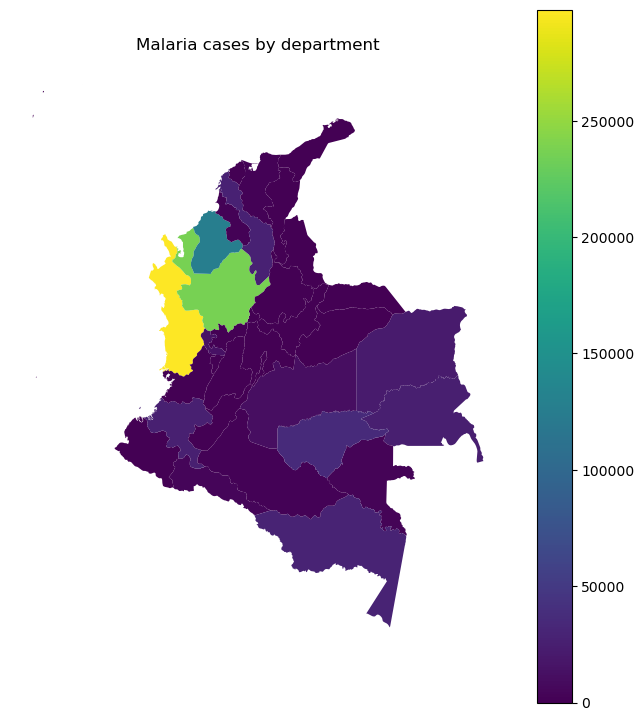

In [5]:
df_dep = agg_malaria_by_department()
plot_malaria_map_departments(df_dep, title="Malaria cases by department") # Plot malaria by departament (absolute numbers) 

### Download climate data

In [6]:
download_climate_(download_chirps=False, download_terraclimate=False)  # Set in False to download from repository. Set in True to download directly from databases, takes approximately 30~40 min in total to download and clean. 

[3/3] Done.


## Calculate indicators and indexes

### Malaria incidence weekly

Constructing output variables, relative malaria cases... 


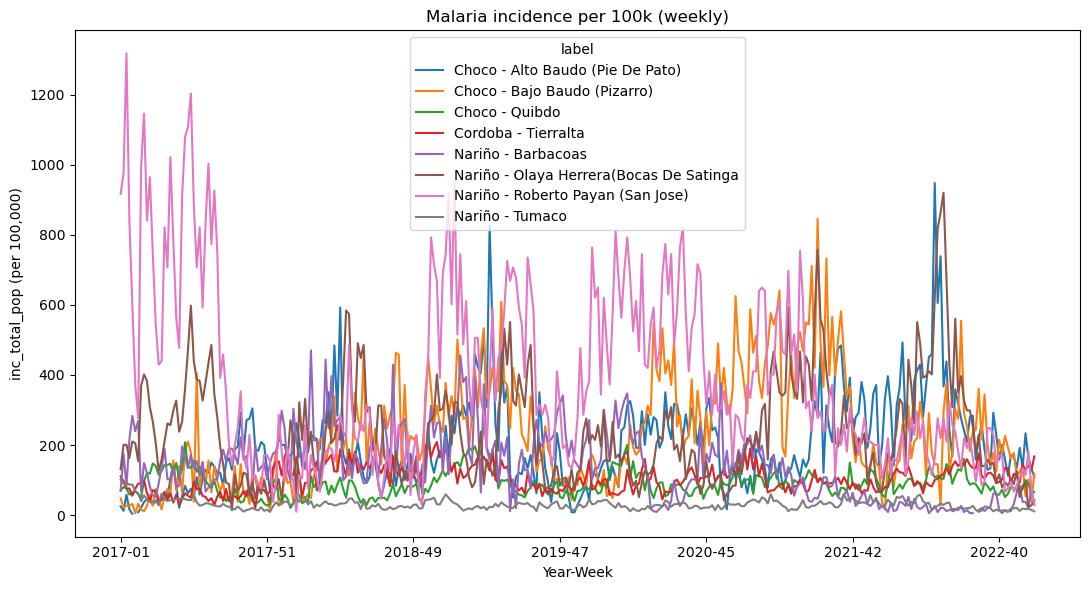

In [7]:
df_week = malaria_weekly_indicators(
    malaria_csv="data_raw/malaria_agg.csv",
    persons_csv="data_raw/cnper2018.csv",
    year_from=2017
)

### Malaria aggregated

In [8]:
df_malaria_total = build_malaria_features_total(df_week)

Constructing output variables, total malaria cases... 


### Vulnerability index

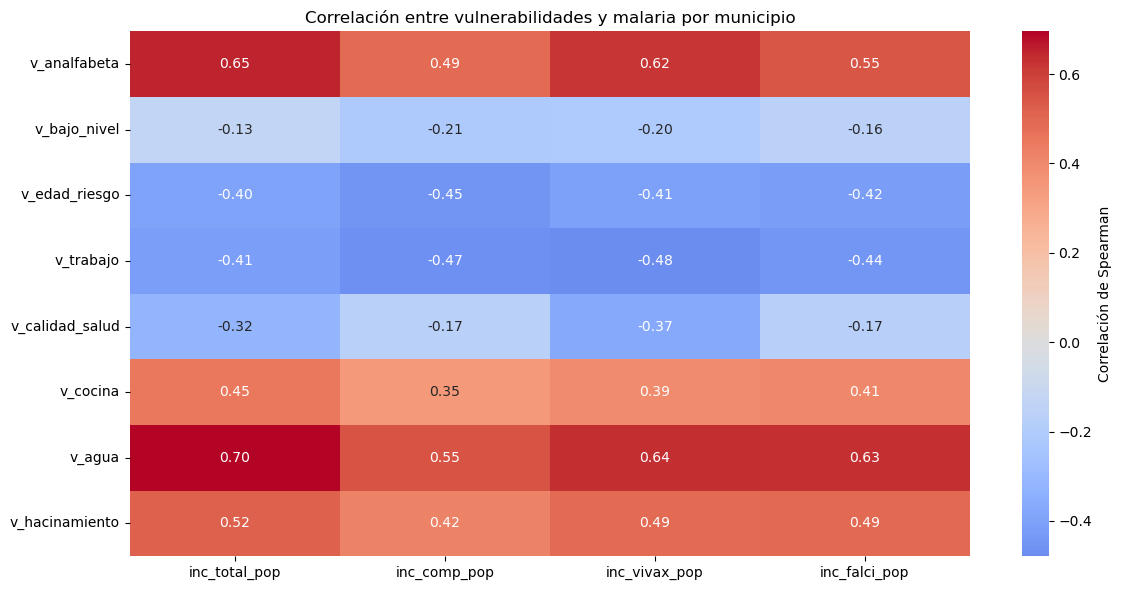

In [9]:
df_vuln_mpio = build_vulnerability_index( df_malaria_total)

### Maps

[*] Downloading GeoJSON from OpenDataSoft…
[*] Valid 5-digit mpio_code ratio: 100.0%
[✓] Saved: data_raw/colombia_mpios\colombia_mpios_opendatasoft.gpkg | data_raw/colombia_mpios\colombia_mpios_opendatasoft.shp
IV_mpio


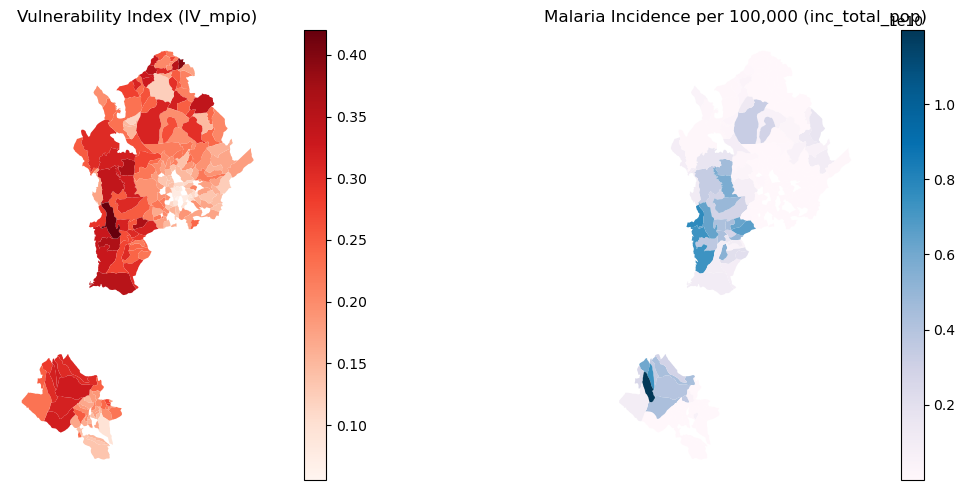

precip_mean


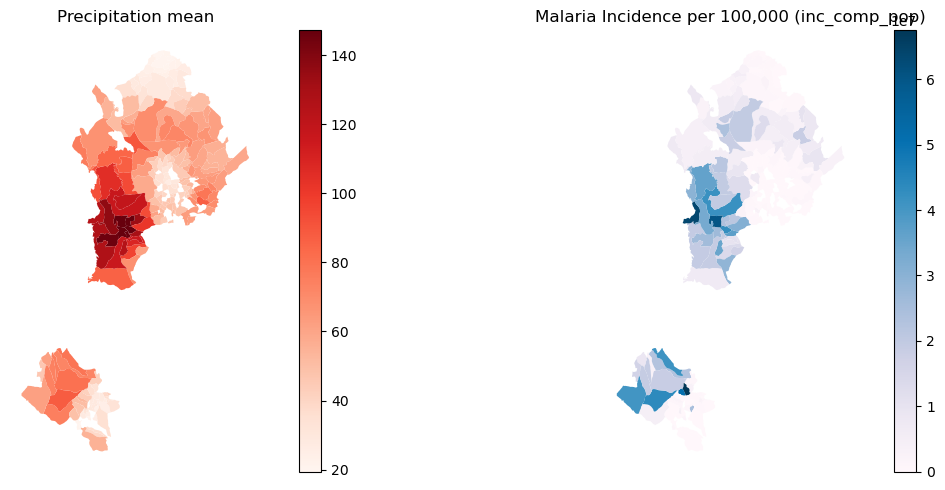

precip_sum


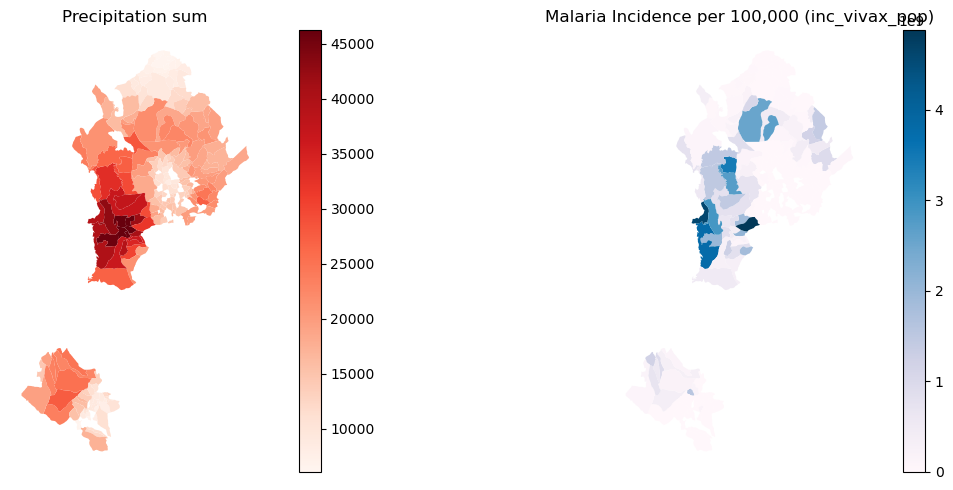

tmean_mean_c


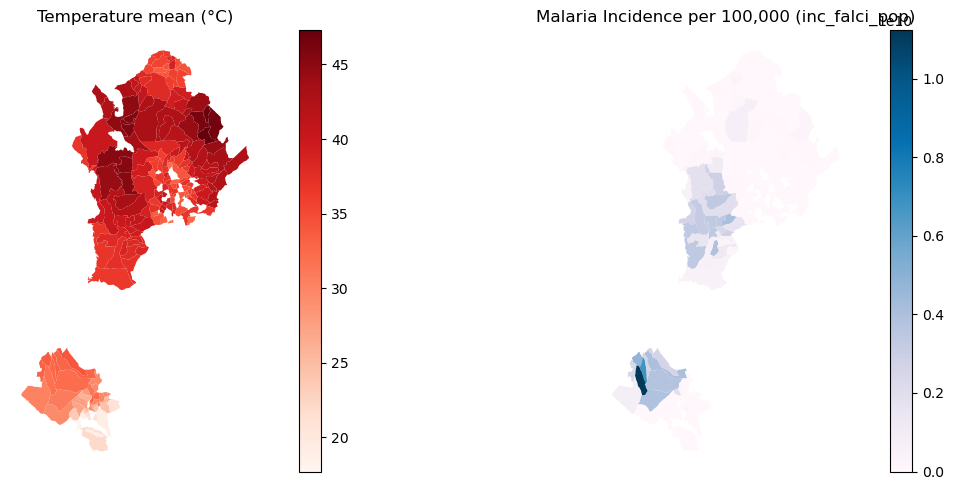

In [19]:
gdf_map = make_maps(df_vuln_mpio, df_malaria_total)

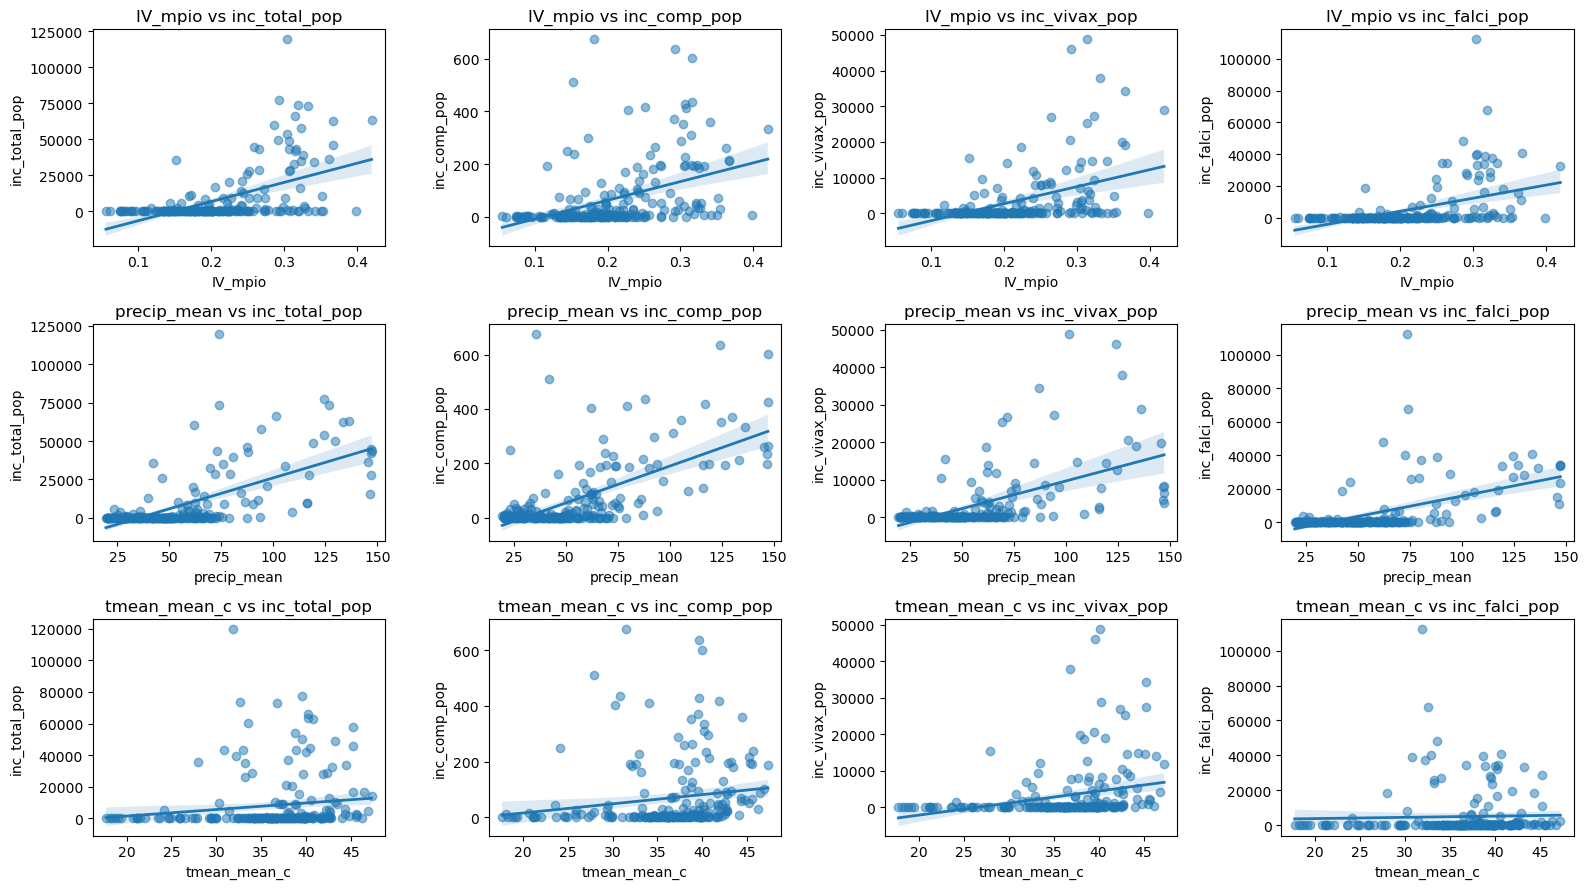

In [16]:
plot_iv_and_climate_vs_malaria(
    gdf_map,
    inc_vars=None,
    iv_col="IV_mpio",
    climate_vars=None,
    cell_size=(4, 3),
)

('WARNING: ', 93, ' is an island (no neighbors)')

=== Global Moran's I (per variable) ===
     variable       I     p_sim       z      EI      VI   n
      IV_mpio  0.6032  0.0010**  12.957 -0.0048  0.0022 210
 inc_comp_pop  0.5335  0.0010**  11.472 -0.0048  0.0022 210
inc_falci_pop  0.6464  0.0010**  13.878 -0.0048  0.0022 210
inc_total_pop  0.6142  0.0010**  13.192 -0.0048  0.0022 210
inc_vivax_pop  0.4122  0.0010**   8.887 -0.0048  0.0022 210
  precip_mean  0.8839  0.0010**  18.939 -0.0048  0.0022 210
 tmean_mean_c  0.9045  0.0010**  19.378 -0.0048  0.0022 210

Significance at α=0.05: * p<0.05, ** p<0.01, *** p<0.001

=== LISA cluster counts (masked by significance) ===
variable                    HH    LH    LL    HL     ns   total
---------------------------------------------------------------
inc_total_pop               27     2    53     0    128     210
inc_comp_pop                25     5    37     1    142     210
inc_vivax_pop               18     3    56     0    133     2

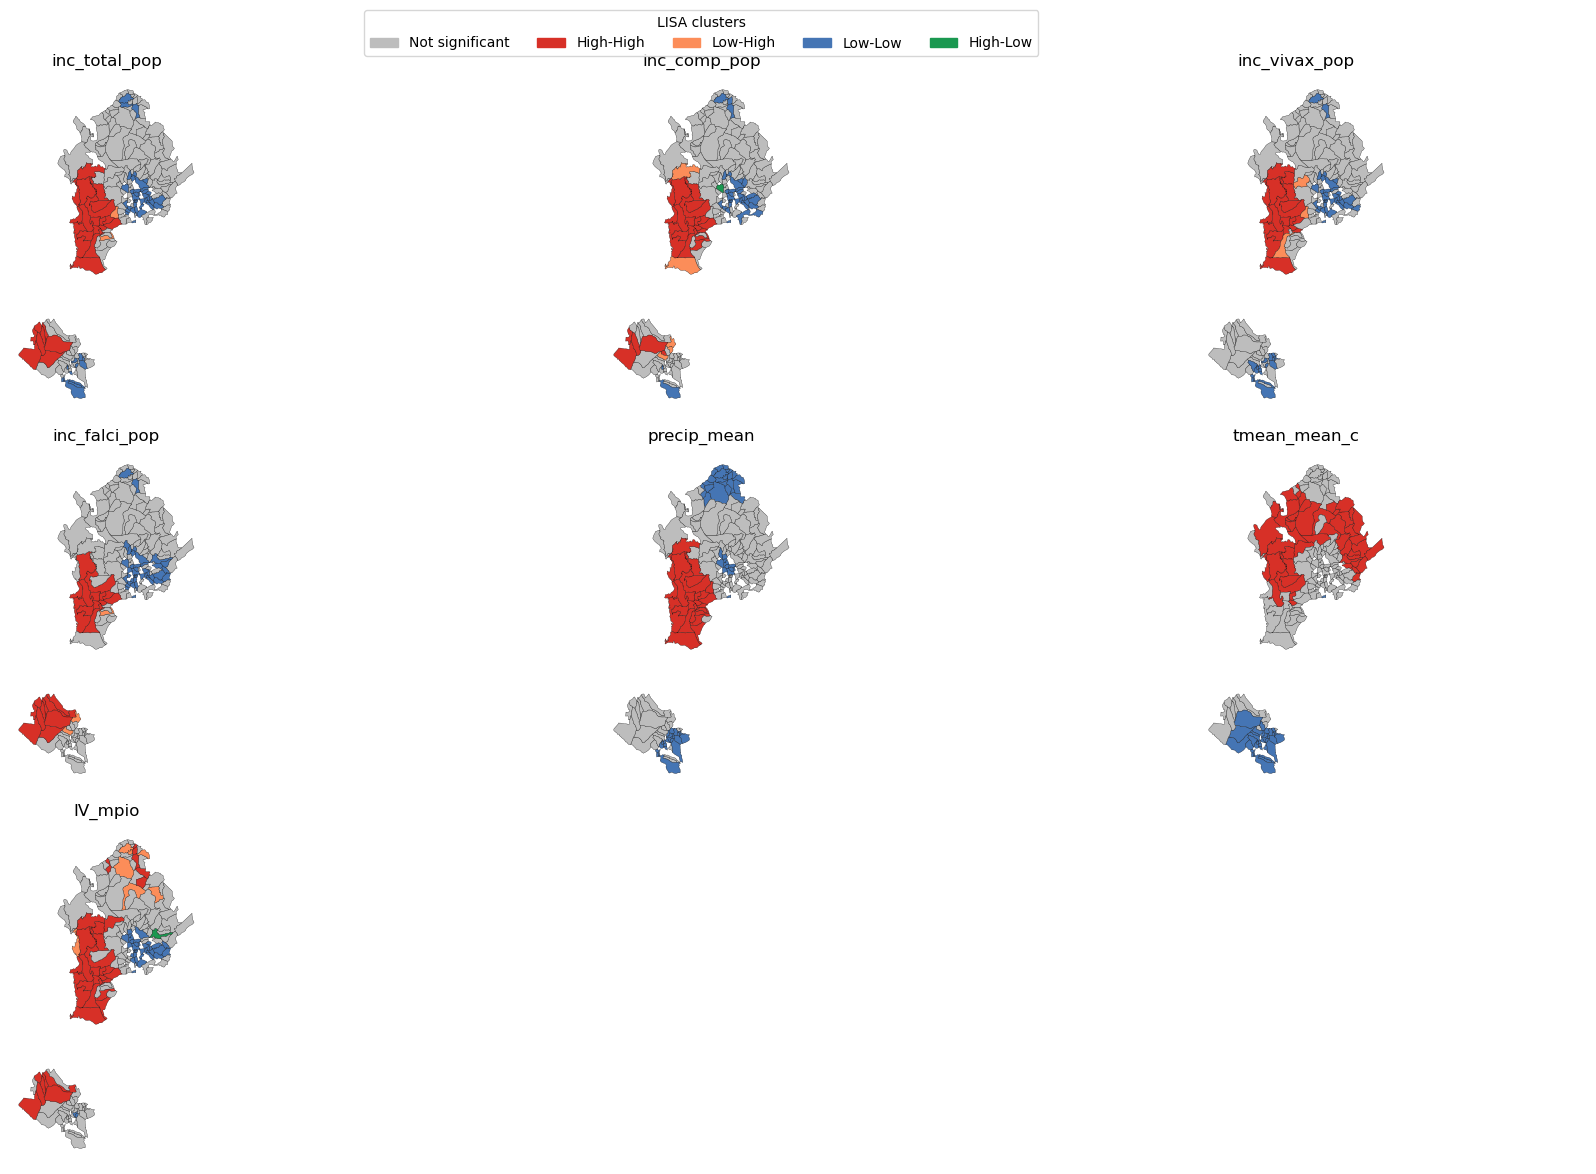

In [26]:
malaria_cols = ['inc_total_pop','inc_comp_pop','inc_vivax_pop','inc_falci_pop']
climate_cols = ['precip_mean', 'tmean_mean_c']  
vuln_col = 'IV_mpio'                     

# 2) Compute weights + Moran/LISA and augment gdf_map
gdf_map_lisa, moran_summary = compute_spatial_autocorr(
    gdf_map,
    malaria_cols=malaria_cols,
    climate_cols=climate_cols,
    vuln_col=vuln_col,
    weight_kind="Queen"  # or "Rook"
)
print_moran_summary(moran_summary, alpha=0.05)
vars_to_report = ['inc_total_pop','inc_comp_pop','inc_vivax_pop','inc_falci_pop','precip_mean','tmean_mean_c','IV_mpio']
print_lisa_cluster_counts(gdf_map_lisa, vars_to_report, p_threshold=0.05)

# 3) Plot grid (4 malaria + 2 climate + 1 vulnerability = 7 subplots)
vars_to_plot = malaria_cols + climate_vars + [vuln_col]
plot_lisa_grid(gdf_map_lisa, vars_to_plot, ncols=3, figsize=(18, 12), p_threshold=0.05)


In [36]:
# --- helpers: anualizar + estandarizar ---
import numpy as np, pandas as pd, math
import libpysal
from spreg import ML_Lag

def annualize_and_standardize(
    gdf,
    inc_cols=("inc_total_pop","inc_comp_pop","inc_vivax_pop","inc_falci_pop"),
    years=6,
    pred_cols=("IV_mpio","precip_mean","tmean_mean_c"),
):
    g = gdf.copy()
    for c in inc_cols:
        g[f"{c}_ann"]   = g[c] / years
        s = g[f"{c}_ann"].std(ddof=0); m = g[f"{c}_ann"].mean()
        g[f"{c}_ann_z"] = (g[f"{c}_ann"] - m) / s if s not in (0, np.nan) else g[f"{c}_ann"]*0
    for c in pred_cols:
        if c in g.columns:
            s = g[c].std(ddof=0); m = g[c].mean()
            g[f"{c}_z"] = (g[c] - m) / s if s not in (0, np.nan) else g[c]*0
    return g

def _p_from_z(z):
    # two-sided p using erf (sin SciPy)
    if z is None or not np.isfinite(z): return np.nan
    Phi = 0.5*(1.0 + math.erf(abs(z)/math.sqrt(2.0)))
    return 2.0*(1.0 - Phi)

def fit_sdm_with_wx(gdf, y_col, x_cols, weight_kind="Queen"):
    # pesos
    W = (libpysal.weights.Rook.from_dataframe(gdf) if weight_kind.lower()=="rook"
         else libpysal.weights.Queen.from_dataframe(gdf))
    W.transform = "r"

    # matrices
    y = gdf[[y_col]].to_numpy()
    X = gdf[x_cols].to_numpy()

    # WX
    try:    WX = W.sparse @ X
    except AttributeError:
        WX = W.full()[0] @ X

    X_aug  = np.hstack([X, WX])
    name_x = list(x_cols) + [f"W_{c}" for c in x_cols]

    # modelo
    sdm = ML_Lag(y, X_aug, W, name_y=y_col, name_x=name_x, name_w="W", method="full")

    # betas / SE (constante + X_aug)  -> z, p
    betas = np.asarray(sdm.betas).ravel()
    ses   = np.asarray(sdm.std_err).ravel()
    names = ["CONSTANT"] + name_x

    coef_map = {}
    for nm, b, se in zip(names, betas, ses):
        z = (b / se) if (se and np.isfinite(se) and se!=0) else np.nan
        coef_map[nm] = {"coef": float(b), "z": float(z) if np.isfinite(z) else np.nan, "p": _p_from_z(z)}

    # tabla de efectos directo/indirecto (WX) por cada predictor original
    rows = []
    for c in x_cols:
        d   = coef_map.get(c,  {}).get("coef", np.nan)
        pd_ = coef_map.get(c,  {}).get("p",    np.nan)
        wi  = f"W_{c}"
        ind = coef_map.get(wi, {}).get("coef", np.nan)
        pi_ = coef_map.get(wi, {}).get("p",    np.nan)
        rows.append({
            "variable": c,
            "direct": d,
            "p_direct": pd_,
            "indirect_WX": ind,
            "p_indirect": pi_,
            "total(direct+indirect)": d + ind if np.isfinite(d) and np.isfinite(ind) else np.nan
        })

    effects = pd.DataFrame(rows)
    # rho (Wy)
    rho = getattr(sdm, "rho", np.nan)
    effects.attrs["rho"] = float(rho) if np.isfinite(rho) else np.nan
    effects.attrs["pseudo_r2"] = getattr(sdm, "pr2", None)
    effects.attrs["n"] = len(gdf)
    return sdm, effects

def print_sdm_effects_table(effects: pd.DataFrame, title="SDM effects (ML_Lag + WX)"):
    if effects is None or effects.empty:
        print("No effects to display."); return
    rho = effects.attrs.get("rho", np.nan)
    pr2 = effects.attrs.get("pseudo_r2", None)
    n   = effects.attrs.get("n", None)

    tbl = effects.copy()
    for c in ["direct","indirect_WX","total(direct+indirect)"]:
        if c in tbl: tbl[c] = tbl[c].map(lambda x: f"{x: .4f}" if pd.notna(x) else "")
    for c in ["p_direct","p_indirect"]:
        if c in tbl: tbl[c] = tbl[c].map(lambda x: f"{x: .4f}" if pd.notna(x) else "")

    print(f"\n=== {title} ===")
    if n is not None and pr2 is not None:
        print(f"n={n}  |  pseudo R²={pr2:.3f}")
    if np.isfinite(rho):
        print(f"rho (W*y) = {rho:.4f}")
    print(tbl[["variable","direct","p_direct","indirect_WX","p_indirect","total(direct+indirect)"]]
          .to_string(index=False))


In [37]:
# 1) anualiza + z-scores
gdf_z = annualize_and_standardize(
    gdf_map,
    inc_cols=["inc_total_pop","inc_comp_pop","inc_vivax_pop","inc_falci_pop"],
    years=6,
    pred_cols=["IV_mpio","precip_mean","tmean_mean_c"]
)

# 2) corre SDM para cada outcome
for y_base in ["inc_total_pop","inc_comp_pop","inc_vivax_pop","inc_falci_pop"]:
    y_col  = f"{y_base}_ann_z"
    x_cols = ["IV_mpio_z","precip_mean_z","tmean_mean_c_z"]
    sdm, eff = fit_sdm_with_wx(gdf_z, y_col=y_col, x_cols=x_cols, weight_kind="Queen")
    print_sdm_effects_table(eff, title=f"SDM effects: {y_base} (annual, z)")


('WARNING: ', 93, ' is an island (no neighbors)')

=== SDM effects: inc_total_pop (annual, z) ===
n=210  |  pseudo R²=0.655
rho (W*y) = 0.5350
      variable  direct p_direct indirect_WX p_indirect total(direct+indirect)
     IV_mpio_z  0.2224   0.0004     -0.0492     0.5595                 0.1732
 precip_mean_z  0.6276   0.0003     -0.3644     0.0629                 0.2632
tmean_mean_c_z  0.1419   0.3729     -0.2316     0.1736                -0.0898
('WARNING: ', 93, ' is an island (no neighbors)')

=== SDM effects: inc_comp_pop (annual, z) ===
n=210  |  pseudo R²=0.534
rho (W*y) = 0.3386
      variable  direct p_direct indirect_WX p_indirect total(direct+indirect)
     IV_mpio_z -0.0013   0.9862      0.2207     0.0212                 0.2194
 precip_mean_z  0.2944   0.1457      0.1093     0.6333                 0.4036
tmean_mean_c_z  0.3718   0.0442     -0.4876     0.0134                -0.1157
('WARNING: ', 93, ' is an island (no neighbors)')

=== SDM effects: inc_vivax_pop (annual, 